<a href="https://colab.research.google.com/github/akshay8867/Refined_Code/blob/master/Journal_Wise_Full_Text_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **In this worksheet, I conducted journal wise topic modelling to extract topics so in case if we want to compare the topics generated by considering the whole text we can.**

In [ ]:
!pip install --upgrade gensim
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()


!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

!pip install pyLDAvis
!pip install nltk
!pip install seaborn 
import seaborn as sns
import gensim
from collections import defaultdict
gensim.__version__

In [ ]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)     

/content/drive
Mounted at /content/drive


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import os
import pickle

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,TfidfModel
from gensim.corpora import Dictionary

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


import nltk
nltk.download('stopwords')

from sklearn.model_selection import GridSearchCV

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pickle
import numpy as np

def generate_corpus(journal_name):
  
  lemma_path=r'/content/drive/MyDrive/Full_Text_With_Lemma_Text'
  lemma_text=[]
  for root,dir,files in os.walk(lemma_path,topdown=True):
    for file in files:
      if file.split("_")[0]==journal_name:
        print(os.path.join(root,file))
        df2 = pd.read_pickle(os.path.join(root,file))
        print(df2.shape)
        data_words = df2['lemma_text'].values.tolist()
        lemma_text=lemma_text + data_words
        print(len(lemma_text))
  print(lemma_text[:2])

  id2word=Dictionary()
  corpus=[id2word.doc2bow(doc,allow_update=True) for doc in lemma_text ]
  tfidf=TfidfModel(corpus,id2word,normalize=True)
  
  a=[]
  for doc in corpus:
    for id, value in tfidf[doc]:
      a.append(value)
  return lemma_text,corpus,tfidf,id2word,a


In [ ]:
def cal_perc(a,perc):
  return np.percentile(a,perc)


In [ ]:
import concurrent.futures
def tf_idf_filteration1(link):

    global tfidf
    global id2word
    global corpus
    words_omitted = []
    finally_omitted_words = []
    word_list = defaultdict(int)

    bow = link[1]
    # print("Original length:{}".format(str(len(bow))))
    low_value_words = []  # reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow] if value>link[2]]
    # print("tfidf len:{}".format(str(len(tfidf_ids))))
    new_bow = [b for b in bow if b[0] in tfidf_ids ]
    # print("New length:{}".format(str(len(new_bow))))

    corpus[link[0]] = new_bow

    # print("New length reflected in corpus:{}".format(str(len(corpus[link[0]]))))
    return 1

In [ ]:
def low_value_filter(perc,corpus,a):
  print("Length of a in low value filter func:{}".format(str(len(a))))
  
  low_value=cal_perc(a,perc)
  
  corpus=[(k,doc,low_value) for k,doc in enumerate(corpus)]
  print(corpus[0])
  i=0
  while i < len(corpus):
      # print(i)
      if i +100< len(corpus):
          # print("hello")
          with concurrent.futures.ThreadPoolExecutor(100) as executor:
              results = executor.map(tf_idf_filteration1, corpus[i:i + 100])
          i=i+100
      else:
        # print("Entered else block")
        with concurrent.futures.ThreadPoolExecutor(100) as executor:
              results = executor.map(tf_idf_filteration1, corpus[i:])
        i=i+100
        break
  


In [ ]:
import time
import shutil

def topic_model(num_topics,corpus,id2word,lemma_text,perc,mallet_path,a,journal_name):
  try:
    print("Length of a in topic model function:{}".format(str(len(a))))
  
    t1=time.perf_counter()
    print("Original Length:{}".format(str(len(corpus[0]))))
    low_value_filter(perc,corpus,a)
    print("New Length:{}".format(str(len(corpus[0]))))
    print("Corpus Updated")
    model = gensim.models.wrappers.LdaMallet(mallet_path, 
                                                  corpus=corpus, 
                                                  num_topics=num_topics, 
                                                  id2word=id2word,
                                                  random_seed=10,
                                                  optimize_interval=100,
                                                  iterations=1000)

    print("Model has been created")
    parent_dir=r'/content/drive/MyDrive/Full_text_topic'
    child_dir="Perc{}Topics{}".format(str(perc),str(num_topics))
    if os.path.exists(os.path.join(parent_dir,journal_name,child_dir)):
      shutil.rmtree(os.path.join(parent_dir,journal_name,child_dir))
      print("Directory has been deleted")

    if not os.path.exists(os.path.join(parent_dir,journal_name,child_dir)):
        os.makedirs(os.path.join(parent_dir,journal_name,child_dir))
        print("Directory has been created")

    final_path=os.path.join(parent_dir,journal_name,child_dir)
    with open(os.path.join(final_path,"{}.pkl".format(str(num_topics))),'wb') as f :
      pickle.dump(model,f)

    with open(model.ftopickeys(),'r') as f:
      with open(os.path.join(final_path,"{}topickeys.txt".format(str(num_topics))),'w') as m:
        m.write(f.read())
    cv_val=['c_npmi','c_v','c_uci','u_mass']
    coherence_values=[] 

    with open(os.path.join(final_path,"{}coherenceval.txt".format(str(num_topics))),'w') as m:
      for coherence in cv_val:
        print(coherence)
        coherencemodel = CoherenceModel(model=model, texts=lemma_text, dictionary=id2word, coherence=coherence)
        coherence_values.append(coherencemodel.get_coherence())
        m.write("{}:{}\n".format(coherence,str(coherencemodel.get_coherence())))

    t2=time.perf_counter()
    print("Ended in {} minutes".format(str((t2-t1)/60)))
    return 1
  except Exception as e:
    print("Exception occured:{}".format(e))
    return 0

Journal Names:journal_names=['Canadian Water Resources Journal','Water Resources Management', 
                   'Sustainable Water Resources Management', 
                   'Journal of Water Resources Planning and Management', 
                   'Water Environment Research',
                   'Integrated Environmental Assessment and Management'
                   ,'Water Resources Research'] 

-**perc_values=[50,75,90,95]**
-**topicno=[5,8,14,20,25**

**I have to do Water Resources Research, Perc50Topics25 after it gets completed**

In [ ]:
import os
perc_values=[75,90,95]
topicno=[5,8,14,20,25]
result_list=[]
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
journal_names=['Water Resources Research']
for journal_name in journal_names:
  lemma_text,corpus,tfidf,id2word,a=generate_corpus(journal_name)
  print("Length of a in main:{}".format(str(len(a))))
  for perc in perc_values:
    print(perc)
    for num_topics in topicno:
      
      mallet_path = '/content/mallet-2.0.8/bin/mallet'
      corpus=[id2word.doc2bow(doc,allow_update=True) for doc in lemma_text ]
      result_list.append(topic_model(num_topics,corpus,id2word,lemma_text,perc,mallet_path,a,journal_name))
      print("{} completed".format(str(num_topics)))


/content/drive/MyDrive/Full_Text_With_Lemma_Text/Water Resources Research_data_lemmatized_full_text_df0.pkl
(1000, 13)
1000
/content/drive/MyDrive/Full_Text_With_Lemma_Text/Water Resources Research_data_lemmatized_full_text_df1000.pkl.pkl
(1000, 13)
2000
/content/drive/MyDrive/Full_Text_With_Lemma_Text/Water Resources Research_data_lemmatized_full_text_df10000.pkl.pkl
(1000, 13)
3000
/content/drive/MyDrive/Full_Text_With_Lemma_Text/Water Resources Research_data_lemmatized_full_text_df11000.pkl.pkl
(1000, 13)
4000
/content/drive/MyDrive/Full_Text_With_Lemma_Text/Water Resources Research_data_lemmatized_full_text_df12000.pkl.pkl
(1000, 13)
5000
/content/drive/MyDrive/Full_Text_With_Lemma_Text/Water Resources Research_data_lemmatized_full_text_df13000.pkl.pkl
(1000, 13)
6000
/content/drive/MyDrive/Full_Text_With_Lemma_Text/Water Resources Research_data_lemmatized_full_text_df14000.pkl.pkl
(1000, 13)
7000
/content/drive/MyDrive/Full_Text_With_Lemma_Text/Water Resources Research_data_lemmat

In [ ]:
topic_path=r'/content/drive/MyDrive/Full_text_topic'
dict_alldocs={}
# dict_commdocs={}
journal_docs={}
journal_docs={}
selected_journals=['Integrated Environmental Assessment and Management',
 'Journal of Water Resources Planning and Management',
 'Journal of Hydrology',
 'Journal of Environmental Management',
 'Water Resources Research',
 'Environmental Modelling and Software',
 'Sustainable Water Resources Management',
 'Water Resources Management',
 'Water Environment Research',
 'Environmental Impact Assessment Review',
 'Annual Review of Environment and Resources',
 'Advances in Water Resources',
 'Canadian Water Resources Journal']


for root,parent_dir,files in os.walk(topic_path,topdown=True):
  for pdir in parent_dir:
    
    if "Perc" in pdir :
      if 'All_Docs' in os.path.join(root,pdir).split("/"): 
        print(os.path.join(root,pdir).split("/")[-1])
        for root1,dir1,files1 in os.walk(os.path.join(root,pdir)):
          file_components=[]
          for file in files1:
            print(os.path.join(root1,file))
            file_components.append(os.path.join(root1,file))
          dict_alldocs[os.path.join(root,pdir).split("/")[-1]]=file_components
      
      if 'Common_Docs' in os.path.join(root,pdir).split("/"):
        print(os.path.join(root,pdir).split("/")[-1])
        for root1,dir1,files1 in os.walk(os.path.join(root,pdir)):
          file_components=[]
          for file in files1:
            print(os.path.join(root1,file))
            file_components.append(os.path.join(root1,file))
          # dict_commdocs[os.path.join(root,pdir).split("/")[-1]]=file_components
      
      if os.path.join(root,pdir).split("/")[-2] in selected_journals:
        
        journal_name=os.path.join(root,pdir).split("/")[-2]
        print(journal_name)
        print(os.path.join(root,pdir).split("/")[-1])
        
        for root1,dir1,files1 in os.walk(os.path.join(root,pdir)):
          file_components=[]
          for file in files1:
            print(os.path.join(root1,file))
            file_components.append(os.path.join(root1,file))
          journal_docs[journal_name+"_"+os.path.join(root,pdir).split("/")[-1]]=file_components
          print(journal_docs.keys())
      
      
      

      
  
  # for dir in dirs:
  #   file_components=[]
  #   if "Perc" in dir:
  #     for root1,dir1,files1 in os.walk(os.path.join(root,dir)):
  #       print(root1.split("/")[-1])
  #       for file in files1:
  #         print(os.path.join(root1,file))
  #         file_components.append(os.path.join(root1,file))
  #     dir_components[root1.split("/")[-1]]=file_components

        # print()

Canadian Water Resources Journal
Perc50Topics5
/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics5/5.pkl
/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics5/5topickeys.txt
/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics5/5coherenceval.txt
dict_keys(['Canadian Water Resources Journal_Perc50Topics5'])
Canadian Water Resources Journal
Perc50Topics8
/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics8/8.pkl
/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics8/8topickeys.txt
/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics8/8coherenceval.txt
dict_keys(['Canadian Water Resources Journal_Perc50Topics5', 'Canadian Water Resources Journal_Perc50Topics8'])
Canadian Water Resources Journal
Perc50Topics14
/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics14/14.

In [ ]:
import matplotlib.pyplot as plt


def plot(coherence_df,coherence_measure):
  test_df=coherence_df[coherence_df['Coherence Type']==coherence_measure].reset_index(drop=True)
  test_df.reset_index(drop=False,inplace=True)
  fig, ax = plt.subplots()
  test_df.plot(x='index',y='Coherence Value',ax=ax)
  ax.legend([coherence_measure]);
  test_df_max=test_df[test_df['Coherence Value']==test_df['Coherence Value'].max()]
  return test_df,test_df_max


In [ ]:
print(journal_docs)

{'Canadian Water Resources Journal_Perc50Topics5': ['/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics5/5.pkl', '/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics5/5topickeys.txt', '/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics5/5coherenceval.txt'], 'Canadian Water Resources Journal_Perc50Topics8': ['/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics8/8.pkl', '/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics8/8topickeys.txt', '/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics8/8coherenceval.txt'], 'Canadian Water Resources Journal_Perc50Topics14': ['/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics14/14.pkl', '/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc50Topics14/14topickeys.txt', '/content/drive/MyDrive/Full

In [ ]:
def prepare_coherence_df(journal_name,journal_docs):
  coherence_df=pd.DataFrame(columns=['Combination','Coherence Type','Coherence Value'])
  
  for k,dct in journal_docs.items():
    # print(k)
    # print(dct)
    # print(k.split("_"))
    try:
      if journal_name ==k.split("_")[0]:
      
        with open(dct[-1],'r') as f:
            for line in f.readlines():
              # print(line.split(":")[0])
              # print(line.split(":")[1][:-1])
              df_=pd.DataFrame([{'Combination':k.split("_")[-1],'Coherence Type':line.split(":")[0]
                                ,'Coherence Value':float(line.split(":")[1][:-1])}])
              # print(df_)
              coherence_df=pd.concat([coherence_df,df_])
              # print("Coherence df")
              # print(coherence_df)
        coherence_df.reset_index(drop=True,inplace=True)
      
    except Exception as e:
      print(e)
  
  print(coherence_df)
  return coherence_df
      


In [ ]:
def prepare_final_df(test_df_u_mass_max,test_df_c_uci_max,test_df_c_npmi_max,test_df_cv_max):
  final_test_df=pd.DataFrame(columns=['index','Combination','Coherence Type','Coherence Value'])
  final_test_df=pd.concat([final_test_df,
                         test_df_u_mass_max,
                         test_df_c_uci_max,
                         test_df_c_npmi_max,
                         test_df_cv_max])
  final_test_df.reset_index(drop=True,inplace=True)
  final_test_df.drop(columns=['index'],inplace=True)
  final_test_df
  return final_test_df


## *Comparing the coherence values and then selecting the best combination per journal to analyse the generated topics*

# **Water Resources Management**

       Combination Coherence Type  Coherence Value
0    Perc50Topics5         c_npmi         0.034339
1    Perc50Topics5            c_v         0.461972
2    Perc50Topics5          c_uci         0.234209
3    Perc50Topics5         u_mass        -0.616266
4    Perc50Topics8         c_npmi         0.042744
..             ...            ...              ...
75  Perc95Topics20         u_mass        -1.384387
76  Perc95Topics25         c_npmi         0.048372
77  Perc95Topics25            c_v         0.521395
78  Perc95Topics25          c_uci         0.241731
79  Perc95Topics25         u_mass        -1.519199

[80 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc50Topics5,u_mass,-0.616266
1,Perc90Topics25,c_uci,0.602548
2,Perc90Topics25,c_npmi,0.069661
3,Perc90Topics20,c_v,0.564898


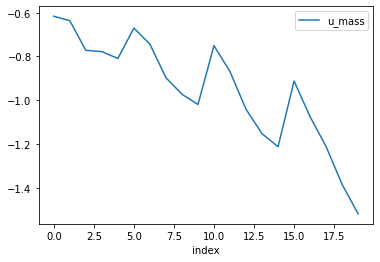

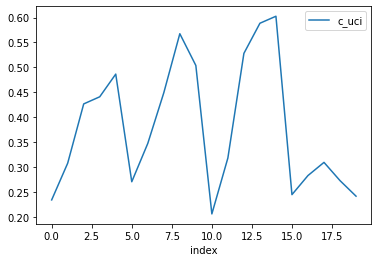

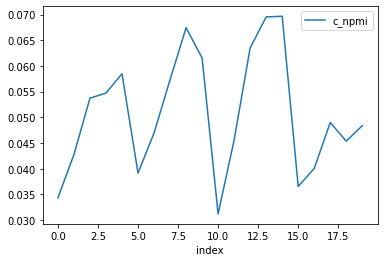

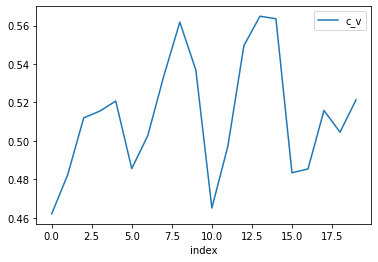

In [ ]:
coherence_df=prepare_coherence_df("Water Resources Management",journal_docs)
wrm_test_df_u_mass,wrm_test_df_u_mass_max=plot(coherence_df,'u_mass')
wrm_test_df_c_uci,wrm_test_df_c_uci_max=plot(coherence_df,'c_uci')
wrm_test_df_c_npmi, wrm_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
wrm_test_df_c_v,wrm_test_df_c_v_max=plot(coherence_df,'c_v')
wrm_final_test_df=prepare_final_df(wrm_test_df_u_mass_max,wrm_test_df_c_uci_max,wrm_test_df_c_npmi_max,wrm_test_df_c_v_max)
wrm_final_test_df

In [ ]:
wrm_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc50Topics5,u_mass,-0.616266
1,Perc90Topics25,c_uci,0.602548
2,Perc90Topics25,c_npmi,0.069661
3,Perc90Topics20,c_v,0.564898


In [ ]:
wrm_final_test_df['Combination'].value_counts()


Perc90Topics25    2
Perc50Topics5     1
Perc90Topics20    1
Name: Combination, dtype: int64

# **Topics of Water Resources Management**

In [ ]:
with open(r'/content/drive/MyDrive/Full_text_topic/Water Resources Management/Perc90Topics20/20topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	0.03276	management policy project stakeholder measure governance development knowledge participant information implementation issue actor action government user plan community tool manage 

1	0.02616	network pipe pressure node leakage valve failure leak pipeline reliability head tank diameter distribution_network energy pump wdn sensor epanet hydrant 

2	0.0419	precipitation temperature climate change impact year scenario basin period runoff projection simulate lake streamflow snow land_use catchment effect day winter 

3	0.03395	irrigation crop farmer yield canal farm soil season production cost land requirement pond productivity rice loss availability efficiency allocation return 

4	0.03384	cost consumption price household service utility company city efficiency sector respondent conservation pay consumer pricing production income industry investment tariff 

5	0.04394	criterion indicator index weight alternative rank decision score assessment evaluation attribute group preference

# **Water Resources Research**

       Combination Coherence Type  Coherence Value
0    Perc50Topics5         c_npmi         0.027987
1    Perc50Topics5            c_v         0.424494
2    Perc50Topics5          c_uci         0.202307
3    Perc50Topics5         u_mass        -0.575362
4    Perc50Topics8         c_npmi         0.041955
5    Perc50Topics8            c_v         0.473887
6    Perc50Topics8          c_uci         0.320402
7    Perc50Topics8         u_mass        -0.642591
8   Perc50Topics14         c_npmi         0.045717
9   Perc50Topics14            c_v         0.483344
10  Perc50Topics14          c_uci         0.359425
11  Perc50Topics14         u_mass        -0.682532
12  Perc50Topics20         c_npmi         0.047644
13  Perc50Topics20            c_v         0.496097
14  Perc50Topics20          c_uci         0.394539
15  Perc50Topics20         u_mass        -0.755201
16   Perc75Topics5         c_npmi         0.034500
17   Perc75Topics5            c_v         0.457630
18   Perc75Topics5          c_u

,Combination,Coherence Type,Coherence Value
0,Perc50Topics5,u_mass,-0.575362
1,Perc90Topics20,c_uci,0.569577
2,Perc90Topics20,c_npmi,0.064359
3,Perc90Topics20,c_v,0.548784


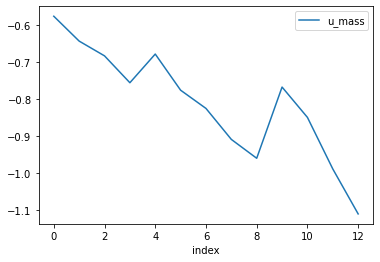

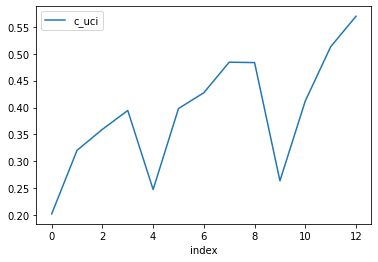

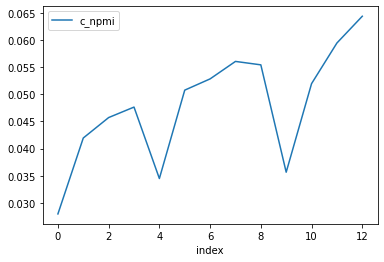

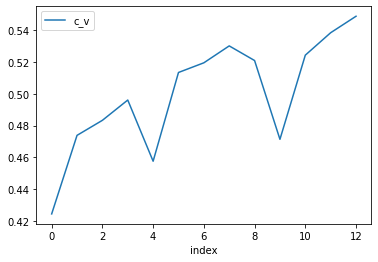

In [ ]:
coherence_df=prepare_coherence_df("Water Resources Research",journal_docs)
wrr_test_df_u_mass,wrr_test_df_u_mass_max=plot(coherence_df,'u_mass')
wrr_test_df_c_uci,wrr_test_df_c_uci_max=plot(coherence_df,'c_uci')
wrr_test_df_c_npmi, wrr_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
wrr_test_df_c_v,wrr_test_df_c_v_max=plot(coherence_df,'c_v')
wrr_final_test_df=prepare_final_df(wrr_test_df_u_mass_max,wrr_test_df_c_uci_max,wrr_test_df_c_npmi_max,wrr_test_df_c_v_max)
wrr_final_test_df

In [ ]:
wrr_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc50Topics5,u_mass,-0.575362
1,Perc90Topics20,c_uci,0.569577
2,Perc90Topics20,c_npmi,0.064359
3,Perc90Topics20,c_v,0.548784


In [ ]:
wrr_final_test_df['Combination'].value_counts()

Perc90Topics20    3
Perc50Topics5     1
Name: Combination, dtype: int64

# **Topics of Water Resources Research**

In [ ]:
with open(r'/content/drive/MyDrive/Full_text_topic/Water Resources Research/Perc90Topics20/20topickeys.txt') as f:
  for line in f.readlines():
    print(line)

0	0.06279	precipitation year basin climate period station trend drought region streamﬂow month season variability summer record day scenario impact winter simulate 

1	0.04048	sediment rate bed particle transport run erosion sand colloid experiment grain gravel stress size deposition channel deposit bar gravel_be article 

2	0.06578	distribution site sample forecast probability variable variance regression input estimator estimation correlation statistic sequence type set series moment generate information 

3	0.05196	phase saturation pressure experiment gas pore interface air permeability ﬂow sample column curve sand oil porosity medium drainage image capillary_pressure 

4	0.09288	solution equation problem element function approximation boundary_condition solve matrix head vector scheme expression define node exp fig aquifer theory formulation 

5	0.05364	flow velocity depth wave layer region channel section turbulence bed structure profile stress density direction slope step roughne

# **Sustainable Water Resources Management**

      Combination Coherence Type  Coherence Value
0   Perc50Topics5         c_npmi         0.024080
1   Perc50Topics5            c_v         0.439706
2   Perc50Topics5          c_uci         0.162655
3   Perc50Topics5         u_mass        -0.598067
4   Perc50Topics8         c_npmi         0.038426
..            ...            ...              ...
63  Perc95Topics5         u_mass        -1.041755
64  Perc95Topics8         c_npmi        -0.014378
65  Perc95Topics8            c_v         0.430912
66  Perc95Topics8          c_uci        -1.017483
67  Perc95Topics8         u_mass        -1.092569

[68 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc50Topics5,u_mass,-0.598067
1,Perc75Topics8,c_uci,0.186895
2,Perc50Topics20,c_npmi,0.039317
3,Perc50Topics8,c_v,0.497963


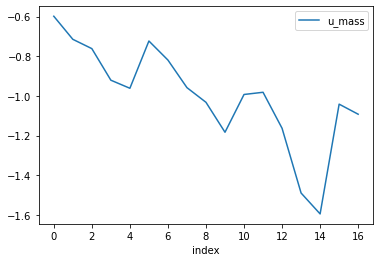

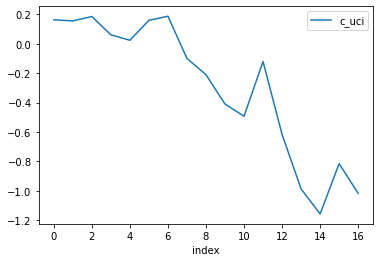

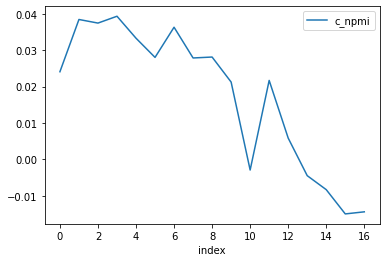

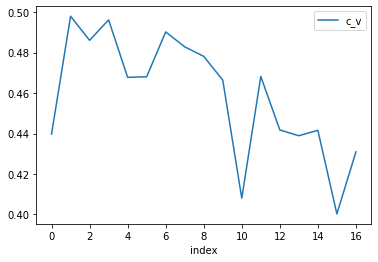

In [ ]:
coherence_df=prepare_coherence_df("Sustainable Water Resources Management",journal_docs)
swrm_test_df_u_mass, swrm_test_df_u_mass_max=plot(coherence_df,'u_mass')
swrm_test_df_c_uci, swrm_test_df_c_uci_max=plot(coherence_df,'c_uci')
swrm_test_df_c_npmi, swrm_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
swrm_test_df_c_v, swrm_test_df_c_v_max=plot(coherence_df,'c_v')
swrm_final_test_df=prepare_final_df(swrm_test_df_u_mass_max,swrm_test_df_c_uci_max,swrm_test_df_c_npmi_max,swrm_test_df_c_v_max)
swrm_final_test_df

In [ ]:
swrm_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc50Topics5,u_mass,-0.598067
1,Perc75Topics8,c_uci,0.186895
2,Perc50Topics20,c_npmi,0.039317
3,Perc50Topics8,c_v,0.497963


In [ ]:
swrm_final_test_df['Combination'].value_counts()

Perc75Topics8     1
Perc50Topics8     1
Perc50Topics5     1
Perc50Topics20    1
Name: Combination, dtype: int64

# **Topics of Sustainable Water Resources Management**

In [ ]:
with open(r'/content/drive/MyDrive/Full_text_topic/Sustainable Water Resources Management/Perc50Topics8/8topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	0.1704	treatment wastewater concentration removal process surface temperature adsorption effect cell solution reduction treat plant cod ion test growth waste rate 

1	0.32019	groundwater soil area map zone basin land_use slope class land image technique runoff factor surface parameter recharge datum remote_sense page 

2	0.29497	model datum parameter estimate reservoir simulate simulation flow observe predict scenario period equation input basin prediction station obtain network performance 

3	0.3823	sample groundwater concentration quality water_quality parameter pollution source soil range contamination ion index lake irrigation type group season chemistry river 

4	0.22858	irrigation crop demand soil scenario country farmer groundwater canal requirement system basin agriculture depth increase land production yield availability field 

5	0.38534	management policy household community cost project plan consumption resource supply service infrastructure city problem access issue gove

# **Canadian Water Resources Journal**

       Combination Coherence Type  Coherence Value
0    Perc50Topics5         c_npmi         0.026239
1    Perc50Topics5            c_v         0.452187
2    Perc50Topics5          c_uci         0.002215
3    Perc50Topics5         u_mass        -0.687085
4    Perc50Topics8         c_npmi         0.054974
..             ...            ...              ...
75  Perc95Topics20         u_mass        -1.419325
76  Perc95Topics25         c_npmi        -0.007370
77  Perc95Topics25            c_v         0.433562
78  Perc95Topics25          c_uci        -1.086783
79  Perc95Topics25         u_mass        -1.674277

[80 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc50Topics5,u_mass,-0.687085
1,Perc50Topics20,c_uci,0.482165
2,Perc75Topics20,c_npmi,0.062214
3,Perc75Topics20,c_v,0.544450


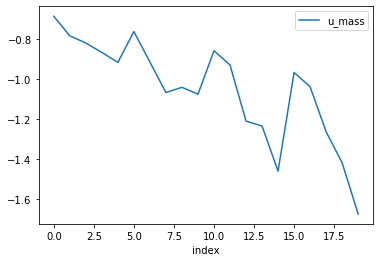

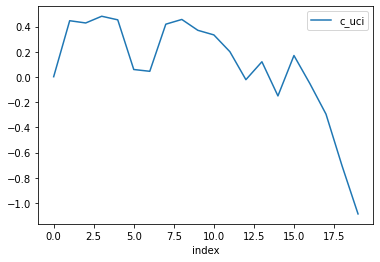

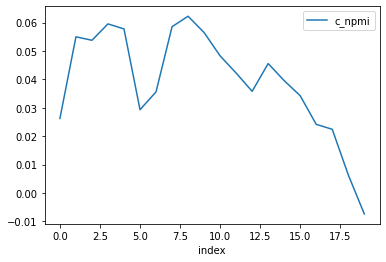

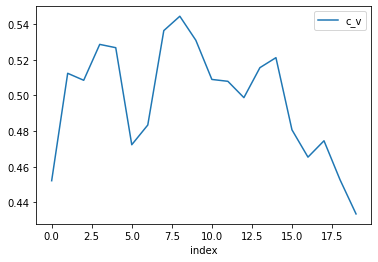

In [ ]:
coherence_df=prepare_coherence_df("Canadian Water Resources Journal",journal_docs)
cwrj_test_df_u_mass, cwrj_test_df_u_mass_max=plot(coherence_df,'u_mass')
cwrj_test_df_c_uci, cwrj_test_df_c_uci_max=plot(coherence_df,'c_uci')
cwrj_test_df_c_npmi, cwrj_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
cwrj_test_df_c_v, cwrj_test_df_c_v_max=plot(coherence_df,'c_v')
cwrj_final_test_df=prepare_final_df(cwrj_test_df_u_mass_max,cwrj_test_df_c_uci_max,cwrj_test_df_c_npmi_max,cwrj_test_df_c_v_max)
cwrj_final_test_df

In [ ]:
cwrj_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc50Topics5,u_mass,-0.687085
1,Perc50Topics20,c_uci,0.482165
2,Perc75Topics20,c_npmi,0.062214
3,Perc75Topics20,c_v,0.544450


In [ ]:
cwrj_final_test_df['Combination'].value_counts()

Perc75Topics20    2
Perc50Topics5     1
Perc50Topics20    1
Name: Combination, dtype: int64

# **Topics of Canadian Water Resources Journal**

In [ ]:
with open(r'/content/drive/MyDrive/Full_text_topic/Canadian Water Resources Journal/Perc75Topics20/20topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	0.03492	groundwater figure surface recharge aquifer region area model ﬂow unit sample sediment layer map bedrock zone group deposit concentration thickness 

1	0.04391	flood area damage loss ﬂood risk cost development program map city municipality land flooding government ﬂoode floodplain property zone design 

2	0.07319	project study plan dam basin benefit development ln construction thls supply proposal build phase land cost review planning propose impact 

3	0.08699	resource program management problem policy research government issue development agency country strategy people pollution planning environment activity conference recommendation goal 

4	0.0421	pour dan sont par station qui eau donc gion du concentration service tre production autre tude bit usage bec de_la 

5	0.04617	irrigation wetland crop farm farmer cost percent benefit land estimate production soil agriculture risk lrrigation adoption drainage yield irrigate emission 

6	0.0517	energy plant power cost temperature

# **Journal of Water Resources Planning and Management**

       Combination Coherence Type  Coherence Value
0    Perc50Topics5         c_npmi         0.020600
1    Perc50Topics5            c_v         0.406136
2    Perc50Topics5          c_uci         0.129146
3    Perc50Topics5         u_mass        -0.565461
4    Perc50Topics8         c_npmi         0.033959
..             ...            ...              ...
75  Perc95Topics20         u_mass        -1.296225
76  Perc95Topics25         c_npmi         0.044537
77  Perc95Topics25            c_v         0.500917
78  Perc95Topics25          c_uci         0.194038
79  Perc95Topics25         u_mass        -1.384008

[80 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc50Topics5,u_mass,-0.565461
1,Perc75Topics25,c_uci,0.438594
2,Perc75Topics20,c_npmi,0.054351
3,Perc90Topics20,c_v,0.513532


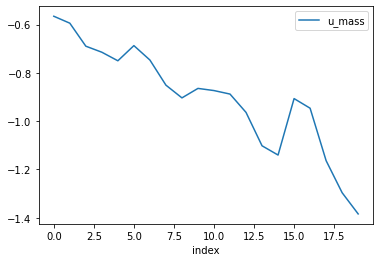

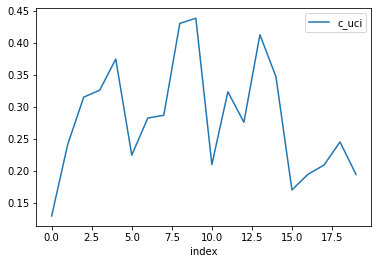

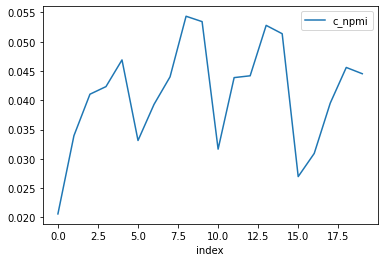

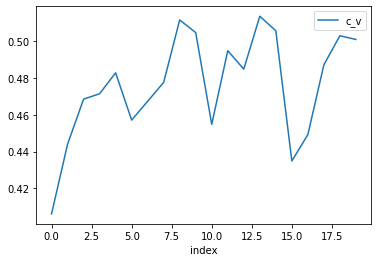

In [ ]:
coherence_df=prepare_coherence_df("Journal of Water Resources Planning and Management",journal_docs)
jwrp_test_df_u_mass, jwrp_test_df_u_mass_max=plot(coherence_df,'u_mass')
jwrp_test_df_c_uci, jwrp_test_df_c_uci_max=plot(coherence_df,'c_uci')
jwrp_test_df_c_npmi, jwrp_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
jwrp_test_df_c_v, jwrp_test_df_c_v_max=plot(coherence_df,'c_v')
jwrp_final_test_df=prepare_final_df(jwrp_test_df_u_mass_max,jwrp_test_df_c_uci_max,jwrp_test_df_c_npmi_max,jwrp_test_df_c_v_max)
jwrp_final_test_df

In [ ]:
jwrp_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc50Topics5,u_mass,-0.565461
1,Perc75Topics25,c_uci,0.438594
2,Perc75Topics20,c_npmi,0.054351
3,Perc90Topics20,c_v,0.513532


In [ ]:
jwrp_final_test_df['Combination'].value_counts()

Perc75Topics25    1
Perc90Topics20    1
Perc50Topics5     1
Perc75Topics20    1
Name: Combination, dtype: int64

# **Topics of Journal of Water Resources Planning and Management**

In [ ]:
with open(r'/content/drive/MyDrive/Full_text_topic/Journal of Water Resources Planning and Management/Perc90Topics20/20topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	0.0365	network sensor node quality source detection concentration event contamination cid location water_quality contaminant injection chlorine attack monitoring detect impact response 

1	0.02523	water supply system transfer user shortage allocation city basin source drought surface conservation withdrawal availability sector permit groundwater market consumption 

2	0.04153	storm runoff basin area sediment land_use reduction load soil land stream bmp watershed rainfall site stormwater drainage watershe development water_quality 

3	0.07084	cost cid ﬂow treatment capacity option site coefﬁcient deﬁne plant streamﬂow beneﬁts plan wastewater beneﬁt length dollar budget efﬁciency program 

4	0.05313	solution optimization problem network constraint solve search node objective_function algorithm objective iteration formulation step generation matrix author population vector procedure 

5	0.05791	scenario year drought strategy project stage site decision uncertainty expect deficit risk co

# **Water Environment Research**

       Combination Coherence Type  Coherence Value
0    Perc50Topics5         c_npmi         0.029813
1    Perc50Topics5            c_v         0.454448
2    Perc50Topics5          c_uci         0.209384
3    Perc50Topics5         u_mass        -0.703414
4    Perc50Topics8         c_npmi         0.040037
..             ...            ...              ...
75  Perc95Topics20         u_mass        -1.634457
76  Perc95Topics25         c_npmi         0.016174
77  Perc95Topics25            c_v         0.469459
78  Perc95Topics25          c_uci        -0.537555
79  Perc95Topics25         u_mass        -1.798454

[80 rows x 3 columns]


,Combination,Coherence Type,Coherence Value
0,Perc50Topics5,u_mass,-0.703414
1,Perc50Topics25,c_uci,0.437022
2,Perc75Topics20,c_npmi,0.056119
3,Perc75Topics20,c_v,0.530974


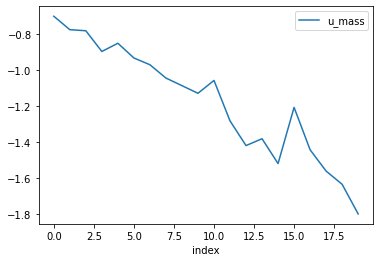

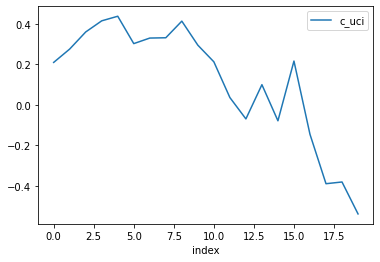

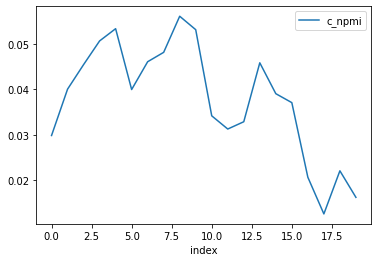

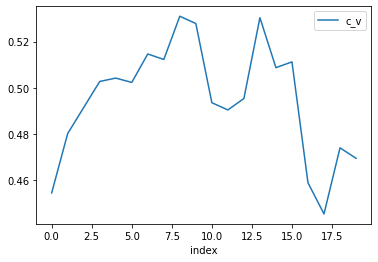

In [ ]:
coherence_df=prepare_coherence_df("Water Environment Research",journal_docs)
wer_test_df_u_mass, wer_test_df_u_mass_max=plot(coherence_df,'u_mass')
wer_test_df_c_uci, wer_test_df_c_uci_max=plot(coherence_df,'c_uci')
wer_test_df_c_npmi, wer_test_df_c_npmi_max=plot(coherence_df,'c_npmi')
wer_test_df_c_v, wer_test_df_c_v_max=plot(coherence_df,'c_v')
wer_final_test_df=prepare_final_df(wer_test_df_u_mass_max,wer_test_df_c_uci_max,wer_test_df_c_npmi_max,wer_test_df_c_v_max)
wer_final_test_df

In [ ]:
wer_final_test_df

,Combination,Coherence Type,Coherence Value
0,Perc50Topics5,u_mass,-0.703414
1,Perc50Topics25,c_uci,0.437022
2,Perc75Topics20,c_npmi,0.056119
3,Perc75Topics20,c_v,0.530974


In [ ]:
wer_final_test_df['Combination'].value_counts()


Perc75Topics20    2
Perc50Topics5     1
Perc50Topics25    1
Name: Combination, dtype: int64

# **Topics of Water Environment Research**

In [ ]:
with open(r'/content/drive/MyDrive/Full_text_topic/Water Environment Research/Perc75Topics20/20topickeys.txt','r') as f:
  for line in f.readlines():
    print(line)

0	0.08937	cell bacteria biofilm culture growth microorganism strain activity substrate sequence organism isolate medium gene abundance biomass biodegradation community probe population 

1	0.08597	model parameter equation estimate predict simulation datum design dog simulate error factor response variable function coefficient prediction coefﬁcient distribution case 

2	0.04364	emission production energy algae impact gas produce require source waste nutrient oil state fuel industry page hydraulic_fracture yield activity site 

3	0.07088	system flow velocity tank particle air power design aeration volume depth bubble ﬂow gas pressure device oxygen surface mix diffuser 

4	0.03506	runoff site area stormwater soil flow storm sediment discharge surface design rainfall volume event pollutant pond bmp depth infiltration tss 

5	0.08719	cost control management facility technology foam process assessment design reuse program approach project problem author propose research evaluation state city